In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from datetime import datetime
from datetime import timedelta

init_notebook_mode(connected = True)

## 0. Чтение данных и преобработка ##

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv') # пользователи
order = pd.read_csv('olist_orders_dataset.csv') # заказы
items = pd.read_csv('olist_order_items_dataset.csv') # товарные позиции, входящие в заказы

In [3]:
# Проверка данных на наличие дубликатов

if (len(customers.drop_duplicates())-len(customers))== 0 \
and (len(order.drop_duplicates())-len(order))==0 \
and (len(items.drop_duplicates())-len(items))==0:
    print("В датафреймах отсутствуют дубликаты")
else:
    print("В датафреймах найдены дубликаты")

В датафреймах отсутствуют дубликаты


In [4]:
# Проверяю датафреймы на целостность (наличие пустых значений - NaN)

if len(customers[customers.isna().any(axis=1)]) > 0:
    print("В датафрейме customers есть пустые значения!")
    
if len(order[order.isna().any(axis=1)]) > 0:
    print("В датафрейме order есть пустые значения!")
    
if len(items[items.isna().any(axis=1)]) > 0:
    print("В датафрейме items есть пустые значения!")

В датафрейме order есть пустые значения!


Поскольку в трех из четырех наших датафреймов найдены пустые значения, установим природу этих пустот. Поочередно изучим данные в датафреймах. 

Для дальнейшего поиска пустых значений в датафреймах введу функцию, которая на вход берет датафрейм, проверяет значения в колонках датафрейма на наличие пустых значений и возвращает список колонок, в которых пустые значения присутствуют

In [5]:
# Функция поиска пустых значений по столбцам датафрейма

def check_empty(df):
    empty_cols = []
    for col in df.columns:
        if df[col].isna().any():
            empty_cols.append(col)
    if empty_cols:
        return f"В столбце {', '.join(empty_cols)} найдены пустые значения."
    else:
        return "Пустые значения не найдены."

### customers - таблица с уникальными идентификаторами пользователей:###
*customer_id* — идентификатор пользователя. \
*customer_unique_id* — уникальный идентификатор пользователя.\
*customer_zip_code_prefix* — почтовый индекс пользователя. \
*customer_city* — город доставки пользователя. \
*customer_state* — штат доставки пользователя.

In [6]:
# Проведем проверку на пустоты с помощью написанной функции

print(check_empty(customers))

Пустые значения не найдены.


In [7]:
# Проводим проверку типа данных

customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

### order - таблица заказов:###
*order_id* —  уникальный идентификатор заказа (номер чека) \
*customer_id* —  позаказный идентификатор пользователя \
*order_status* —  статус заказа \
*order_purchase_timestamp* —  время создания заказа \
*order_approved_at* —  время подтверждения оплаты заказа \
*order_delivered_carrier_date* —  время передачи заказа в логистическую службу \
*order_delivered_customer_date* —  время доставки заказа \
*order_estimated_delivery_date* —  обещанная дата доставки 

In [8]:
# Проведем проверку на пустоты с помощью написанной функции

print(check_empty(order))

В столбце order_approved_at, order_delivered_carrier_date, order_delivered_customer_date найдены пустые значения.


**Анализ пустот в датасете:**

- order_approved_at - может иметь пустое значение, если оплата еще не подтверждена 
- order_delivered_carrier_date - может иметь пустое значение, если заказ еще не передан в курьерскую службу 
- order_delivered_customer_date - может иметь пустое значение, если еще заказ не доставлен

In [9]:
# Проводим проверку типа данных

order.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [10]:
# Приводим даты в тип данных datetime
order['order_purchase_timestamp'] = pd.to_datetime(order['order_purchase_timestamp'])
order['order_approved_at'] = pd.to_datetime(order['order_approved_at'])
order['order_delivered_carrier_date'] = pd.to_datetime(order['order_delivered_carrier_date'])
order['order_delivered_customer_date'] = pd.to_datetime(order['order_delivered_customer_date'])
order['order_estimated_delivery_date'] = pd.to_datetime(order['order_estimated_delivery_date'])

### items - товарные позиции, входящие в заказы:###
*order_id* —  уникальный идентификатор заказа (номер чека) \
*order_item_id* —  идентификатор товара внутри одного заказа \
*product_id* —  ид товара (аналог штрихкода) \
*seller_id* — ид производителя товара \
*shipping_limit_date* —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике \
*price* —  цена за единицу товара \
*freight_value* —  вес товара

In [11]:
# Проведем проверку на пустоты с помощью написанной функции

print(check_empty(items))

Пустые значения не найдены.


In [12]:
# Проводим проверку типа данных

items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [13]:
# Приводим даты в тип данных datetime
items['shipping_limit_date'] = pd.to_datetime(items['shipping_limit_date'])

С учетом проведенной предподготовки данных проведем анализ и ответим на вопросы продакт-менеджера

## 1. Предварительное исследование данных ##

Исследуем полученные данные, а также установим, что должно считаться покупкой. 
Для начала исследуем датасеты, чтобы выяснить:
- какие статусы заказов хранятся в таблице order;
- как статус заказа зависит от статуса оплаты.

In [14]:
# Попробуем выяснить, когда происходит оплата заказа

order.query('order_approved_at != "NaN"').order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'approved'], dtype=object)

Необходимо подробнее рассмотреть статус заказа "недоступен" при подтверждении оплаты

In [15]:
order.query('order_approved_at != "NaN" and order_status == "unavailable"').reset_index()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
1,586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
2,687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
3,737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
4,1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27
...,...,...,...,...,...,...,...,...,...
604,99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27
605,99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19
606,99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
607,99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [16]:
order.query('order_approved_at == "NaN" and order_status == "unavailable"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


При статусе заказа "Недоступен" есть прогнозная дата доставки, однако отсутствует дата передачи заказа в логистическую службу. Вероятно это ситуация, при которой после оформления заказа покупателем и оплаты, продавец инициирует отмену заказа по каким-то причинам (например, отсутствие товаров на складе) 

Делаем вывод о том, что оплата, вероятно, происходит сразу после создания заказа, таким образом считать покупкой только факт её оплаты - нецелесообразно

In [17]:
# Проверим, при каких статусах заказа отсутсвует подтверждение оплаты

order.query('order_approved_at == "NaN"').order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

Оплата заказа, как мы выяснили, производится после его создания, на этапе подтверждения. Исходя из данных, отмена заказа может произойти как после оплаты, так и до. \
Однако, вызывают сомнения данные по доставленным заказам. По каким-то причинам факт оплаты не подтвержден, хотя товар доставлен. Необходимо детально изучить этот вопрос

In [18]:
order.query('order_approved_at == "NaN" and order_status == "delivered"').reset_index()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
1,16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
2,19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
3,22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
4,23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
5,26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
6,38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
7,39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
8,48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
9,61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


Всего у 14-ти заказов отсутствует статус подтверждения оплаты. Такая сиутация возможна по следущим причинам: 
- задержка в подтверждении транзакции со стороны банка;
- возврат заказа после получения.

In [19]:
# Проверим, есть ли среди наших заказов дубликаты, производим поиск дубликатов по номеру заказов

order[order.duplicated(['order_id'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


Поскольку дубликаты по номеру заказа не найдены, исключаем тот факт, что на каждое действие по заказу данные в таблицу добавляются новой строкой (а не обновляются).

Для понимания процесса необходимо понять, какой статус присваивается заказу, когда он находится в логистической службе

In [20]:
# Для этого выведем уникальные статусы заказов до появления отметки о передаче в службу логистики

order.query('order_delivered_carrier_date == "NaN"').order_status.unique()

array(['invoiced', 'processing', 'unavailable', 'canceled', 'created',
       'approved', 'delivered'], dtype=object)

По полученным данным делаем вывод о том, что заказ передается в службу логистики при статусе "shipped".
Кроме того, необходимо подробно изучить статус "delivered", поскольку логика процесса в таком случае не очень понятна

In [21]:
order.query('order_delivered_carrier_date == "NaN" and order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


Исходя из полученного результата делаем вывод о том, что при записи данных мог произойти сбой, поэтому информация по этим заказам записалась в нашу таблицу с ошибкой

In [22]:
# Произведем обратное действие и посмотрим, при каком статусе заказа заказ уже передан в логистическую службу

order.query('order_delivered_carrier_date != "NaN"').order_status.unique()

array(['delivered', 'shipped', 'canceled'], dtype=object)

По результатам запроса можно сделать ввод о том, что заказ может быть отменен даже после передачи заказа в службу логистики. Служба логистики, в свою очередь, занимается отгрузкой со склада и доставкой

Любая покупка может не завершиться полным циклом, но нам важно, что покупатель завершил все необходимые с его стороны действия (заказ + оплата), а у нас есть в наличии эти товары (т.е. статус заказа не может быть "недоступен")

С учетом проведенного анализа, считаем, что покупка - это заказ, который находится в статусах: "processing", "shipped", "delivered"

## 2. Работа с данными ##

#### Наш продакт-менеджер попросил дать ответы на следующие вопросы####

### Вопрос 1. Сколько у нас пользователей, которые совершили покупку только один раз?###

In [23]:
# Поскольку данные по заказам и пользователям хранятся в разных датафреймах, для ответа на вопрос необходимо предварительно их объединить

order_customer = customers.merge(order, on = 'customer_id', how = 'inner')

In [24]:
# Фильтруем датафрейм по отобранным статусам
# Группируем по уникальным пользователям
# Отбираем только тех пользователей, у кого order_id == 1 

order_customer.query('order_status == ["processing", "shipped", "delivered"]') \
              .groupby('customer_unique_id', as_index = False) \
              .agg({'order_id' : 'count'}) \
              .query('order_id == 1') \
              .count() \
              .customer_unique_id

91814

In [25]:
# Рассчитаем, сколько всего пользователей совершили у нас покупки

order_customer.query('order_status == ["processing", "shipped", "delivered"]') \
              .groupby('customer_unique_id', as_index = False) \
              .agg({'order_id' : 'count'}) \
              .count() \
              .customer_unique_id

94686

Таким образом, **97 %** (т.е. 91814) **покупателей** совершили всего **одну** покупку в нашем магазине. 

Ввиду того, что показатель довольно высокий, следует подробнее исследовать данные, чтобы выяснить причины, по которым покупатели не возвращаются в наш магазин, а также с учетом полученных результатов разработать мероприятия по увеличению заказов.

Предполагаемые причины:

- проблемы при оформлении заказа: для оценки посчитаем конверсию в покупку;
- длительный процесс подтверждения и сборки: рассчитаем время от момента создания заказа до передачи заказа в логистическую службу;
- длительный процесс доставки: рассчитаем время доставки;
- нарушение сроков доставки: вычислим, сколько заказов доставлены позже планируемой даты доставки.

In [26]:
# Посчитаем количество уникальных пользователей, которые зарегистрировались в нашем магазине

order_customer.groupby('customer_unique_id', as_index = False) \
              .agg({'order_id' : 'count'}) \
              .count() \
              .customer_unique_id

96096

In [27]:
# Рассчитаем конверсию в покупку

91814 / 96096 * 100 

95.5440392940393

Поскольку конверсия в покупку составляет **96 %**, исключаем тот факт, что проблема связана с процессом оформления заказа

(0.0, 6000.0)

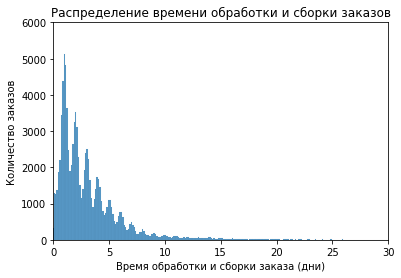

In [28]:
# Рассчитаем, какое время занимает процесс подтверждения заказа, выставления счета и сборки в днях
# Построим график распределения

order_customer['time_order'] = (order_customer['order_delivered_carrier_date'] - order_customer['order_purchase_timestamp']) / np.timedelta64 ( 1 , 'D')
sns.histplot(data=order_customer, x="time_order")
plt.xlabel("Время обработки и сборки заказа (дни)")
plt.ylabel("Количество заказов")
plt.title("Распределение времени обработки и сборки заказов")
plt.xlim([0, 30])
plt.ylim([0, 6000])

In [29]:
# Посмотрим на характеристику времени обработки и сборки заказа

order_customer['time_order'].describe()

count    97658.000000
mean         3.234050
std          3.611996
min       -171.212419
25%          1.128967
50%          2.204676
75%          4.071777
max        125.775521
Name: time_order, dtype: float64

Поскольку 75% заказов лежит в интервале до 4 дней, скорее всего ключевая причина не в длительности конкретно этого процесса

(0.0, 6000.0)

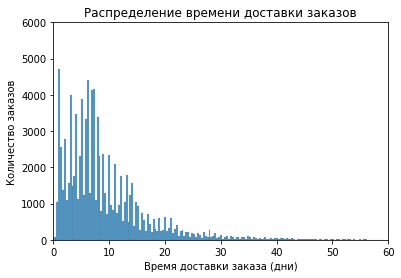

In [30]:
# Рассчитаем, какое время занимает процесс доставки
# Построим график распределения

order_customer['time_delivery'] = (order_customer['order_delivered_customer_date'] - order_customer['order_delivered_carrier_date']) / np.timedelta64 ( 1 , 'D')
sns.histplot(data=order_customer, x="time_delivery")
plt.xlabel("Время доставки заказа (дни)")
plt.ylabel("Количество заказов")
plt.title("Распределение времени доставки заказов")
plt.xlim([0, 60])
plt.ylim([0, 6000])

In [31]:
# Посмотрим на характеристику времени доставки

order_customer['time_delivery'].describe()

count    96475.000000
mean         9.330547
std          8.760122
min        -16.096169
25%          4.099948
50%          7.099769
75%         12.029115
max        205.190972
Name: time_delivery, dtype: float64

В среднем на доставку заказов уходит 9 дней, при этом половина заказов доставляется менее чем за 7 дней. 

Если это приемлемо для покупателей, то причина вероятнее всего не в длительности доставки. Т.е. для углубленного анализа необходимо понимать, какой сервис в этой части мы обещаем клиенту.

Стоит рассмотреть, насколько плановое время доставки отличалось от фактического.

(-60.0, 60.0)

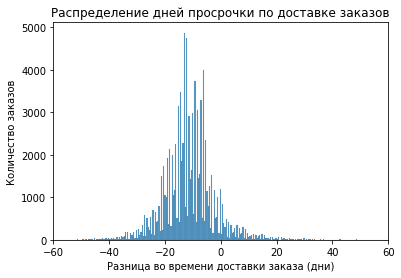

In [32]:
# Рассчитаем, разницу между плановым временем доставки и фактическим
# Построим график распределения

order_customer['time_delta_delivery'] = (order_customer['order_delivered_customer_date'] - order_customer['order_estimated_delivery_date']) / np.timedelta64 ( 1 , 'D')
sns.histplot(data=order_customer, x="time_delta_delivery")
plt.xlabel("Разница во времени доставки заказа (дни)")
plt.ylabel("Количество заказов")
plt.title("Распределение дней просрочки по доставке заказов")
plt.xlim([-60, 60])
# plt.ylim([0, 6000])

In [33]:
# Посмотрим на характеристику дельты сроков доставки

order_customer['time_delta_delivery'].describe()

count    96476.000000
mean       -11.179120
std         10.186113
min       -146.016123
25%        -16.244384
50%        -11.948941
75%         -6.390000
max        188.975081
Name: time_delta_delivery, dtype: float64

Из полученных данных делаем вывод, что большая часть заказов доставлялась раньше планируемого срока.

Таким образом, для выяснения причин необходимо провести более глубокий анализ: возможно, покупатели не удовлетворены качеством товаров или доставленные товары ненадлежащего вида и т.д. (запросим больше вводных у продакт-менеджера по продукту)

### Вопрос 2. Сколько заказов в месяц в среднем не доставляется по разным причинам?###

Недоставленный заказ - это заказ, жизненный цикл которого завершен, т.е. заказ должен находиться в статусе, при котором доставка в дальнейшем не может производиться.

Под такими заказами принимаем заказы в статусе "canceled" и в статусе "unavailable".

In [34]:
# Отфильтруем и сгруппируем данные по статусу заказа и месяцу
# Посчитаем количество заказов
# Снова сгруппируем данные по статусу заказа
# Посчитаем среднее от количества заказов

order_customer.query('order_status == "canceled" or order_status == "unavailable"') \
              .groupby([pd.Grouper(freq = 'M', key = 'order_estimated_delivery_date'),'order_status'], as_index = False) \
              .agg({'order_id' : 'count'}) \
              .groupby('order_status', as_index = False)\
              .agg({'order_id' : 'mean'}) \
              .rename(columns = {'order_id' : 'mean'}) \
              .sort_values('mean', ascending = False)

,order_status,mean
1,unavailable,29.000000
0,canceled,24.038462


In [35]:
# Исследуем данные по недоставленным заказам в разрезе месяцев
# Посчитаем количество заказов без доставки со статусом "отменен"

no_delivery = order_customer.query('order_status == "canceled"') \
                            .groupby(['order_estimated_delivery_date','order_status'], as_index = False) \
                            .agg({'order_id' : 'count'})

no_delivery["month_number"] = no_delivery["order_estimated_delivery_date"].apply(lambda x: x.month)
no_delivery = no_delivery[['month_number', 'order_status', 'order_id']]

no_delivery = no_delivery.groupby(['month_number', 'order_status'], as_index=False) \
                         .agg({'order_id':'sum'}) \
                         .sort_values('month_number')

In [36]:
# Исследуем данные по недоставленным заказам в разрезе месяцев
# Посчитаем количество заказов без доставки со статусом "отменен"

no_delivery1 = order_customer.query('order_status == "unavailable"') \
                            .groupby(['order_estimated_delivery_date','order_status'], as_index = False) \
                            .agg({'order_id' : 'count'})

no_delivery1["month_number"] = no_delivery1["order_estimated_delivery_date"].apply(lambda x: x.month)
no_delivery1 = no_delivery1[['month_number', 'order_status', 'order_id']]

no_delivery1 = no_delivery1.groupby(['month_number', 'order_status'], as_index=False) \
                         .agg({'order_id':'sum'}) \
                         .sort_values('month_number')

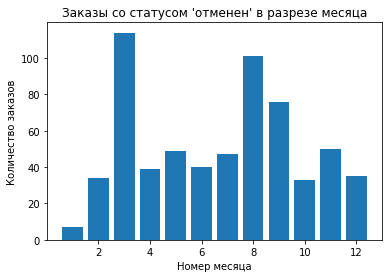

In [37]:
# Визуализируем данные

plt.bar(no_delivery['month_number'], no_delivery['order_id'])
plt.xlabel("Номер месяца")
plt.ylabel("Количество заказов")
plt.title("Заказы со статусом 'отменен' в разрезе месяца")
plt.show()

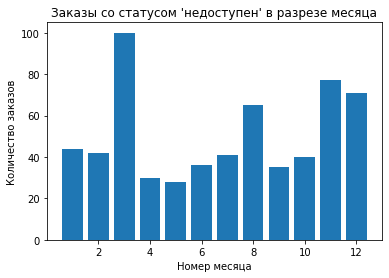

In [38]:
# Визуализируем данные

plt.bar(no_delivery1['month_number'], no_delivery1['order_id'])
plt.xlabel("Номер месяца")
plt.ylabel("Количество заказов")
plt.title("Заказы со статусом 'недоступен' в разрезе месяца")
plt.show()

Таким образом, в среднем в месяц не доставляется заказов:

- по причине того, что заказ недоступен: 29 заказов 
- по причине того, что заказ отменен: 24 заказа

Также на март приходится больше всего заказов, по которым доставка не была осуществлена. Необходимо углубиться в события, которые происходили в марте, чтобы выяснить причину такого явления.

### Вопрос 3. По каждому товару определить, в какой день недели товар чаще всего покупается###

Покупка - заказ со статусом *("processing", "shipped", "delivered")* \
Дата покупки - дата создания заказа *("order_purchase_timestamp")*

In [39]:
# Объединяем данные по заказам и по товарам

order_items = order.merge(items, on = 'order_id') 

In [40]:
# Меняем формат даты покупки на день недели

order_items['order_purchase_timestamp'] = order_items.order_purchase_timestamp.dt.day_name()

In [41]:
# Фильтрую данные по статусу заказа, группирую по товару и дню недели, считаю количество заказов
# Сортирую данные в порядке убывания по количеству заказов

items_f = order_items.query('order_status == ["processing", "shipped", "delivered"]') \
                     .groupby(['product_id','order_purchase_timestamp'], as_index = False) \
                     .agg({'order_id' : 'count'}) \
                     .sort_values('order_id', ascending = False) \

In [42]:
# Сгруппирую датафрейм по продукту и отфильтрую order_id по максимальному значению

items_f1 = items_f.groupby('product_id')['order_id'] \
                  .max() \
                  .reset_index() \
                  .sort_values(['order_id','product_id'], ascending=False)

In [43]:
# Объединю оба датафрейма по полям product_id и order_id

items = items_f.merge(items_f1, on=['product_id', 'order_id'], how='inner')
items

,product_id,order_purchase_timestamp,order_id
0,422879e10f46682990de24d770e7f83d,Wednesday,93
1,99a4788cb24856965c36a24e339b6058,Monday,92
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
3,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
4,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
42292,64367bed3ed96fd9381676fbe33b6443,Sunday,1
42293,643a4049ae3e6df63858575f28cd7b21,Friday,1
42294,643a4049ae3e6df63858575f28cd7b21,Sunday,1
42295,643a66b1dc5dad3de6cb5a41549e72f1,Sunday,1


Таким образом мы вывели информацию по всем дням недели, когда количество покупок для каждого товара максимальное. 

Из этой выгрузки можем опредилить топ самых популярных по продажам дней недели. Т.е. в какой день недели для большинства товаров продажи были максимальные

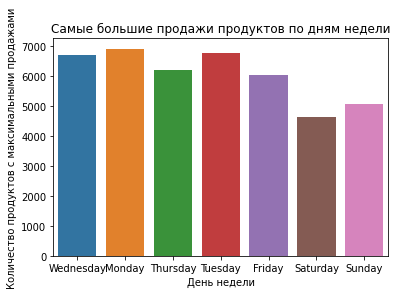

In [44]:
sns.countplot(data=items, x="order_purchase_timestamp")
plt.xlabel("День недели")
plt.ylabel("Количество продуктов с максимальными продажами")
plt.title("Самые большие продажи продуктов по дням недели")
plt.show()

Таким образом, для большинства продуктов самыми "продаваемыми" днями являются понедельник, вторник и среда.

Также интересно узнать, на какие дни недели в целом приходится большее количество проданых товаров

In [45]:
# Считаем сумму заказов по каждому дню недели

items_f2 = items_f.groupby('order_purchase_timestamp', as_index=False).agg({'order_id':'sum'})
items_f2 

,order_purchase_timestamp,order_id
0,Friday,15936
1,Monday,18227
2,Saturday,12072
3,Sunday,13318
4,Thursday,16639
5,Tuesday,18070
6,Wednesday,17477


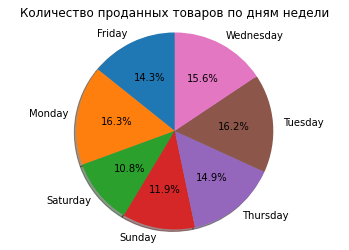

In [46]:
# Выведем график для удобства анализа

plt.pie(items_f2.order_id, labels=items_f2.order_purchase_timestamp, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Количество проданных товаров по дням недели")
plt.show()

Из этого графика видно, что большее количество товаров покупают также в понедельник, вторник и среду.

Также интересно вывести топ-5 самых продаваемых товаров (по количеству проданных единиц товара.

In [47]:
# Группируем по товару, суммируем количество покупок для каждого товара, сортируем по убыванию и берем первые 5 строк

items_f5 = items_f.groupby('product_id', as_index=False) \
                  .agg({'order_id':'sum'}) \
                  .sort_values('order_id', ascending=False)[0:5]
items_f5

,product_id,order_id
21881,aca2eb7d00ea1a7b8ebd4e68314663af,527
19527,99a4788cb24856965c36a24e339b6058,486
8529,422879e10f46682990de24d770e7f83d,484
7294,389d119b48cf3043d311335e499d9c6b,391
7013,368c6c730842d78016ad823897a372db,388


Однако количество продаж не значит, что для нашего магазина эти товары приносят больше всего прибыли.

Выведем топ-5 товаров с наибольшей выручкой за анализируемый период

In [48]:
# Сгруппируем датафрейм с заказами и товарами по продукту и цене, посчитаем количество заказов

items_sum = order_items.groupby(['product_id', 'price'], as_index=False) \
                       .agg({'order_id':'count'})

In [49]:
# Посчитаем выручку по каждому товару по конкретной цене и запишем в новый столбец

items_sum['amount'] = items_sum['order_id'] * items_sum['price']

In [50]:
# Сгруппируем данные по продукту и просуммируем выручку по продукту, отсортируем выручку в порядке убывания и выведем топ-5

items_sum5 = items_sum.groupby('product_id', as_index=False) \
                      .agg({'amount':'sum'}) \
                      .sort_values('amount', ascending=False)[0:5]

items_sum5

,product_id,amount
24086,bb50f2e236e5eea0100680137654686c,63885.00
14068,6cdd53843498f92890544667809f1595,54730.20
27613,d6160fb7873f184099d9bc95e30376af,48899.34
27039,d1c427060a0f73f6b889a5c7c61f2ac4,47214.51
19742,99a4788cb24856965c36a24e339b6058,43025.56


Теперь сравним топ-5 товаров по выручке и топ-5 товаров по количеству продаж

In [51]:
# Объединим две таблицы по product_id

items_sum5.merge(items_f5, on='product_id', how='inner')

,product_id,amount,order_id
0,99a4788cb24856965c36a24e339b6058,43025.56,486


Исходя из полученных данных, делает вывод о том, что только один товар из нашего магазина входит в пятерку лидеров по количеству продаж и выручке

### Вопрос 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?###

Аналогичная ошибка, как и в предыдущем задании относительно даты, здесь не буду снижать балл.

In [52]:
# Объединяем датафреймы заказов, пользователей и товаров

order_customer_items = order_customer.merge(order_items, on = ['order_id', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at', 'order_status', 'customer_id', 'order_estimated_delivery_date'])

In [53]:
# В новый столбец записываем количество недель в каждом месяце

order_customer_items['weeks'] = order_customer_items.order_purchase_timestamp_x.dt.days_in_month / 7

In [54]:
# Записываем в новую колонку месяц из даты покупки 

order_customer_items['month_order'] = order_customer_items.order_purchase_timestamp_x.dt.strftime('%Y-%m')

In [55]:
# Выбираем заказы нужного статуса, группируем по уникальным пользователям, месяцам и числу недель.
# Считаем число покупок
# Снова группипуем данные и суммируем количество заказов

week_count = order_customer_items.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby(['customer_unique_id', 'month_order', 'weeks'], as_index = False) \
    .agg({'order_status' : 'count'}) \
    .groupby(['customer_unique_id', 'month_order', 'weeks'], as_index = False) \
    .agg({'order_status' : 'sum'}) \
    .rename(columns = {'order_status':'sum_order'})

week_count

,customer_unique_id,month_order,weeks,sum_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1
...,...,...,...,...
96553,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,4.285714,2
96554,fffea47cd6d3cc0a88bd621562a9d061,2017-12,4.428571,1
96555,ffff371b4d645b6ecea244b27531430a,2017-02,4.000000,1
96556,ffff5962728ec6157033ef9805bacc48,2018-05,4.428571,1


In [56]:
# В новый столбец записываю среднее количество заказов в неделю, сортирую по убыванию

week_count['mean_orders'] = week_count.sum_order / week_count.weeks
week_count.sort_values('mean_orders', ascending = False)

,customer_unique_id,month_order,weeks,sum_order,mean_orders
75634,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,24,5.419355
74030,c402f431464c72e27330a67f7b94d4fb,2018-02,4.000000,20,5.000000
26184,4546caea018ad8c692964e3382debd19,2017-07,4.428571,21,4.741935
39913,698e1cf81d01a3d389d96145f7fa6df8,2017-08,4.428571,20,4.516129
5817,0f5ac8d5c31de21d2f25e24be15bbffb,2017-11,4.285714,18,4.200000
...,...,...,...,...,...
41802,6e896394a8caa8730dfc4db1d8de3e10,2017-01,4.428571,1,0.225806
41803,6e8a7be1f3d09d448ddb2c78f40d1bdb,2018-01,4.428571,1,0.225806
41805,6e8c0e15a8a6d670899110476f993044,2018-03,4.428571,1,0.225806
41806,6e8cb50d9d4c1bf8f164d8e0b6e75b3f,2018-08,4.428571,1,0.225806


Таким образом, наибольшее среднее количество покупок в неделю совершил покупатель в августе 2018 года. 

### Вопрос 5. Выполните когортный анализ пользователей###

#### В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц ####

Retention — это метрика, отвечающая на вопрос, сколько людей вернулись в день Х (неделю Х, месяц Х) после первого входа в продукт.

Для подсчета Retention используем следующие условия:
- покупка: заказ со статусами - "processing", "shipped", "delivered"
- дата покупки: дата создания заказа - order_purchase_timestamp 
- период анализа: необходимо определить по данным

In [57]:
# Выводим список всех месяцев, чтобы выбрать год, по которому проводим анализ

order_customer_items.month_order.sort_values().unique()

array(['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03',
       '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
       '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
       '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09'],
      dtype=object)

Поскольку полные данные у нас представлены только за 2017 год, проведем анализ за 2017 год

Таким образом, параметры нашего когортного анализа:

- признак формирования когорты: покупка
- размер когорты — временной интервал: 3 месяца после первой покупки
- отчетный период: 2017 год
- анализируемый ключевой показатель: Retention Rate

In [58]:
# Запишем в новый датафрейм данные с покупками за 2017 год

order_customer_items_2017 = order_customer_items.query('month_order <= "2017-12" and month_order >= "2017-01"') 
order_customer_items_2017.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp_x,order_approved_at,order_delivered_carrier_date,...,time_delta_delivery,order_purchase_timestamp_y,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weeks,month_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,-10.558623,Tuesday,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,4.428571,2017-05
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,...,-5.268947,Thursday,1,0be701e03657109a8a4d5168122777fb,8f2ce03f928b567e3d56181ae20ae952,2017-09-20 18:25:11,259.90,22.31,4.285714,2017-09
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,...,-10.469028,Thursday,1,124f74f703e88efe001a10bfa718b6ff,2a7dc43cecabf23403078e2188437d1d,2017-11-22 19:55:41,19.90,16.11,4.285714,2017-11
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,...,-11.072025,Monday,1,6b874ff4c71d18e91079b40396bf176a,b6e1504972665f739dec4facb9943775,2017-12-01 18:01:20,25.30,15.10,4.285714,2017-11
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,...,-11.150301,Saturday,1,3fc00af0f0a8d4ac2933d3900416c977,7a241947449cc45dbfda4f9d0798d9d0,2017-09-14 10:10:17,99.00,18.31,4.285714,2017-09


In [59]:
# Находим дату первой покупки для каждого покупателя
# Группирем данные за 2017 по покупателю, фильрем дату покупки по минимальной дате

first = order_customer_items_2017.groupby('customer_unique_id', as_index=False) \
                                 .agg({'month_order': 'min'}) \
                                 .rename(columns={'month_order': 'date_first'})
first.head()

,customer_unique_id,date_first
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07


In [60]:
# Объединем датасеты 2017 год и первые покупки 2017 года

all_2017 = first.merge(order_customer_items_2017, on='customer_unique_id', how='inner',  right_index=True) \
                .reset_index(drop=True)
all_2017

,customer_unique_id,date_first,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp_x,order_approved_at,...,time_delta_delivery,order_purchase_timestamp_y,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weeks,month_order
0,0000f46a3911fa3c0805444483337064,2017-03,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC,b33ec3b699337181488304f362a6b734,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,...,-1.389734,Friday,1,64b488de448a5324c4134ea39c28a34b,3d871de0142ce09b7081e2b9d1733cb1,2017-03-15 21:05:03,69.00,17.22,4.428571,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10,914991f0c02ef0843c0e7010c819d642,66812,belem,PA,41272756ecddd9a9ed0180413cc22fb6,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,...,-11.108970,Thursday,1,2345a354a6f2033609bbf62bf5be9ef6,ef506c96320abeedfb894c34db06f478,2017-10-18 21:49:17,25.99,17.63,4.428571,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP,d957021f1127559cd947b62533f484f7,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,...,-7.035463,Tuesday,1,c72e18b3fe2739b8d24ebf3102450f37,70a12e78e608ac31179aea7f8422044b,2017-11-22 20:06:52,180.00,16.89,4.285714,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03,3b37fb626fdf46cd99d37ec62afa88ff,25966,teresopolis,RJ,ae76bef74b97bcb0b3e355e60d9a6f9c,delivered,2017-03-04 23:32:12,2017-03-04 23:43:26,...,-27.643657,Saturday,1,e24f73b7631ee3fbb2ab700a9acaa258,0cbcee27c791afa0cdcb08587a2013a8,2017-03-09 23:43:26,135.00,15.12,4.428571,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07,2f29573c8cac5a7be11c5b649078f944,29400,mimoso do sul,ES,6681163e3dab91c549952b2845b20281,delivered,2017-07-18 09:23:10,2017-07-18 09:30:22,...,-11.220266,Tuesday,1,7ca5f56188492e30c50ba64de188aae7,d2374cbcbb3ca4ab1086534108cc3ab7,2017-07-26 09:30:22,13.90,15.10,4.428571,2017-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50859,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,74be082247cd677a147d83ee670e9d53,55250,sanharo,PE,725cf8e9c24e679a8a5a32cb92c9ce1e,delivered,2017-06-08 21:00:36,2017-06-08 21:15:16,...,-26.609722,Thursday,1,c100e5fef1abb5e1c5054d1dac2d83ac,17f51e7198701186712e53a39c564617,2017-06-25 21:15:16,890.00,258.28,4.285714,2017-06
50860,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,74be082247cd677a147d83ee670e9d53,55250,sanharo,PE,725cf8e9c24e679a8a5a32cb92c9ce1e,delivered,2017-06-08 21:00:36,2017-06-08 21:15:16,...,-26.609722,Thursday,2,bbc5419bc92d76e27795c9ec2c233c64,17f51e7198701186712e53a39c564617,2017-06-25 21:15:16,680.00,239.14,4.285714,2017-06
50861,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0ecf8e0a08148af0bf313184f167670a,44054,feira de santana,BA,c71b9252fd7b3b263aaa4cb09319a323,delivered,2017-12-10 20:07:56,2017-12-10 20:16:20,...,-2.063657,Sunday,1,251876e7ba013b87b7262fb2524e2d60,7aa4334be125fcdd2ba64b3180029f14,2017-12-14 20:16:20,64.89,19.69,4.428571,2017-12
50862,ffff371b4d645b6ecea244b27531430a,2017-02,27f584b0f1dc4e610065c240f68b6be0,78552,sinop,MT,fdc45e6c7555e6cb3cc0daca2557dbe1,delivered,2017-02-07 15:49:16,2017-02-07 16:02:44,...,-29.468704,Tuesday,1,13ad6994bda56edfa0a269e3d9a9acb3,54aa8463e87776b5612f4bdc4bd5d4de,2017-02-11 15:49:16,89.90,22.56,4.000000,2017-02


In [61]:
# Группируем по датам первого заказа, других заказов

all_2017_1 = all_2017.groupby(['date_first','month_order'])['customer_unique_id'] \
                                .agg(['nunique', 'count']) \
                                .rename(columns={'nunique': 'all_clients', 'count': 'all_orders'})
all_2017_1

all_clients  all_orders
date_first month_order                         
2017-01    2017-01              755         955
           2017-02                3           3
           2017-03                2           2
           2017-04                1           1
           2017-05                3           3
...                             ...         ...
2017-10    2017-11               31          39
           2017-12               11          14
2017-11    2017-11             7218        8511
           2017-12               40          53
2017-12    2017-12             5442        6162

[77 rows x 2 columns]

Для сравнивнения когорт между собой с в течение 3 месяцев после первой покупки проиндексируем каждую когорту

In [62]:
# Напишем и применим функцию для индексации каждой когорты
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df))
    return df

all_2017_1 = all_2017_1.groupby(level=0).apply(cohort_period)

In [63]:
# Транспонируем таблицу

all_2017_1 = all_2017_1.reset_index().set_index(['cohort_period', 'date_first'])['all_clients'].unstack(0)
all_2017_1

cohort_period,0,1,2,3,4,5,6,7,8,9,10
date_first,,,,,,,,,,,
2017-01,755.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0
2017-02,1705.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0
2017-03,2595.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN
2017-04,2340.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,NaN,NaN
2017-05,3560.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN
2017-06,3114.0,15.0,11.0,12.0,8.0,12.0,12.0,NaN,NaN,NaN,NaN
2017-07,3844.0,20.0,14.0,9.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN
2017-08,4149.0,28.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4091.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# Считаю доли возврата покупателей от первоначального размера когорты

retention = all_2017_1.divide(all_2017_1[0], axis=0)
retention

cohort_period,0,1,2,3,4,5,6,7,8,9,10
date_first,,,,,,,,,,,
2017-01,1.0,0.003974,0.002649,0.001325,0.003974,0.001325,0.003974,0.001325,0.001325,0.003974,0.001325
2017-02,1.0,0.002346,0.002933,0.001173,0.004106,0.001173,0.002346,0.001760,0.001173,0.001760,0.001173
2017-03,1.0,0.005010,0.003468,0.003854,0.003468,0.001541,0.001541,0.003083,0.003468,0.000771,NaN
2017-04,1.0,0.005983,0.002137,0.001709,0.003419,0.002564,0.003419,0.002991,0.002991,NaN,NaN
2017-05,1.0,0.004775,0.004775,0.003933,0.003090,0.003371,0.004213,0.001404,NaN,NaN,NaN
2017-06,1.0,0.004817,0.003532,0.003854,0.002569,0.003854,0.003854,NaN,NaN,NaN,NaN
2017-07,1.0,0.005203,0.003642,0.002341,0.002862,0.002081,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006749,0.003374,0.002651,0.003615,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006844,0.005378,0.002933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Нанесем метрику retention на график:
- по оси Х - номер месяца, когда пользователь вернулся
- по оси Y - дата первой покупки.

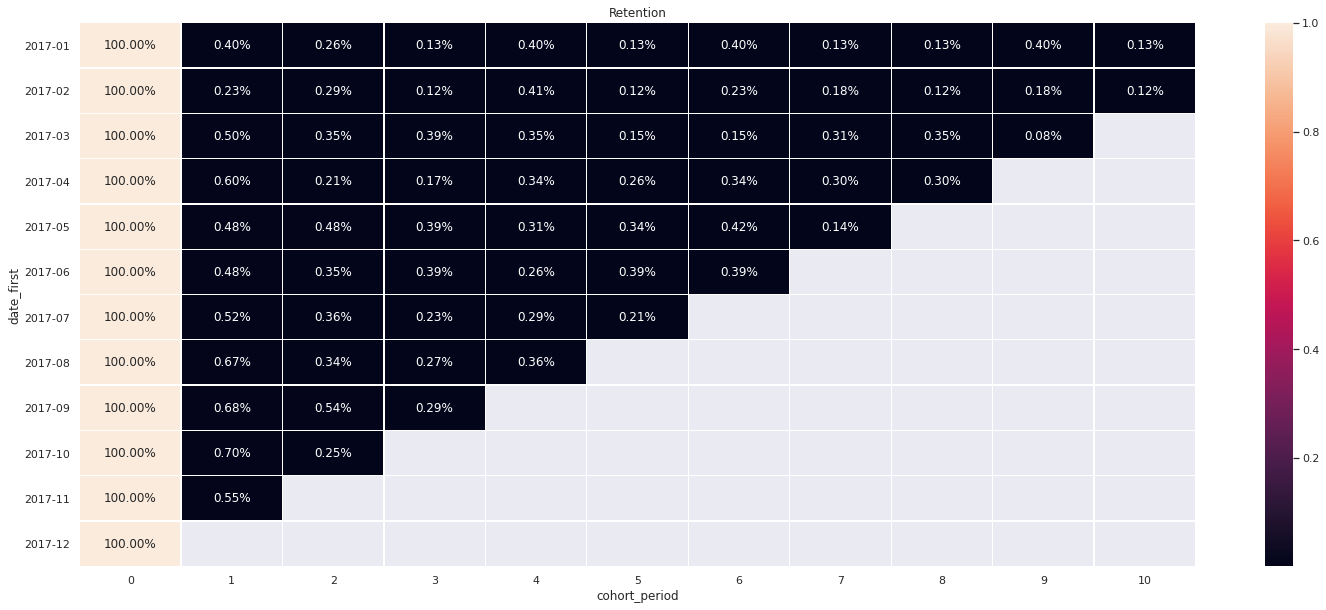

In [65]:
sns.set(style='darkgrid',
        rc={"figure.figsize": (25, 10)})
plt.title('Retention')
sns.heatmap(retention, mask=retention.isnull(), annot=True, fmt='.2%', linewidth=.3)

Самый высокий Retention за третий месяц у тех пользователей, которые совершили первую покупку в **марте, мае и июне** - он составляет **0,39 %**

Интересно, Retention у пользователей, которые совершившили первую покупку в сентябре, в большем объеме возвращались на второй, третий  месяц после покупки. Даже за 4-ый месяц Retention довольно высокий. Для выснения причин клиентского поведения необходимо проанализировать дополнительные данные за этот период.

## Вопрос 6. RFM-сегментация пользователей ##

В кластеризации выбираем следующие метрики:

- R - время от последней покупки пользователя до текущей даты
- F - суммарное количество покупок у пользователя за всё время
- M - сумма покупок за всё время

Для каждого RFM-сегмента построим границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [66]:
# Удаляем строки с пробелами в данных и фильтруем по признаку покупки

RFM = order_customer_items.dropna().query('order_status == ["processing", "shipped", "delivered"]')

In [67]:
# Текущая дата = следующий день после даты заказа

today = RFM.order_purchase_timestamp_x.max() + timedelta(days=1)

In [68]:
# Производим рассчет метрик
# R - время от последней покупки пользователя до текущей даты
# F - суммарное количество покупок у пользователя за всё время (покупка = заказ)
# M - сумма покупок за всё время

rfm_all = RFM.groupby('customer_unique_id', as_index = False) \
             .agg({'order_purchase_timestamp_x': lambda x:(today - x.max()).days, 'order_id': 'count', 'price': 'sum'}) \
             .rename(columns = {'order_purchase_timestamp_x': 'R', 'order_id': 'F', 'price': 'M'})
rfm_all.head()

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


Для распределения пользователей по кластерам используются квантили. Для определения "Лучших" и "Худших" используем более крайние значения квантилей

In [69]:
# Рассчитаем квантили

q = rfm_all.quantile(q=[0.1, 0.4, 0.7, 0.9])
q

,R,F,M
0.1,42.0,1.0,25.98
0.4,177.0,1.0,69.90
0.7,312.0,1.0,139.00
0.9,466.0,2.0,279.99


Исходя из анализа данных в Вопросе 1 большая часть клиентов совершает только одну покупку, таким образом все квантили для метрики F(Частота покупок) равны (кроме квантили 0.9 соответственно)

Прокластеризируем метрики с учетом полученных квантилей

In [70]:
rfm_all.F.value_counts()

1     81728
2      8795
3      1646
4       621
5       241
6       190
7        45
8        16
10       11
11       11
9        10
12        9
14        3
15        3
13        2
20        2
21        1
18        1
24        1
Name: F, dtype: int64

In [71]:
# Исследуем экстремальные значения всех метрик

rfm_all.describe()

,R,F,M
count,93336.000000,93336.000000,93336.000000
mean,237.903853,1.180391,141.621663
std,152.552964,0.620913,215.714143
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.692500
max,714.000000,24.000000,13440.000000


In [72]:
# Разделяем на сегменты метрики

rfm_all['R_ceg'] = pd.cut(rfm_all.R, bins = [0, 32, 184, 367, 715], 
                                     labels = ['4', '3', '2', '1'])
rfm_all['F_ceg'] = pd.cut(rfm_all.F, bins = [0, 1, 3, 6, 25], 
                                     labels = ['1', '2', '3', '4'])
rfm_all['M_ceg'] = pd.cut(rfm_all.M, bins = [0, 20, 70, 140, 13450], 
                                     labels = ['1', '2', '3', '4'])

# меняю тип данных

rfm_all['R_ceg'] = rfm_all['R_ceg'].astype(str)
rfm_all['F_ceg'] = rfm_all['F_ceg'].astype(str)
rfm_all['M_ceg'] = rfm_all['M_ceg'].astype(str)


# суммирую все показатели RFM

rfm_all['RFM'] = rfm_all['R_ceg'] + rfm_all['F_ceg'] + rfm_all['M_ceg']
rfm_all

,customer_unique_id,R,F,M,R_ceg,F_ceg,M_ceg,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,2,212
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214
...,...,...,...,...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00,1,2,4,124
93332,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,2,1,2,212
93333,ffff371b4d645b6ecea244b27531430a,568,1,89.90,1,1,3,113
93334,ffff5962728ec6157033ef9805bacc48,119,1,115.00,3,1,3,313


#### Параметры метрик####

##### R (давность) - время от последней покупки покупателя до текущей даты:

- 1 - > 1 года
- 2 - от 6 месяцев до 1 года
- 3 - от 1 до 6 месяцев
- 4 - < 1 месяца

Чем выше оценка, тер меньше срок от последней покупки

##### F (частота) -  количество покупок у покупателя за всё время:

- 1 - 1 покупка
- 2 - от 2 до 3 покупок
- 3 - от 4 до 6 покупок
- 4 - >= 7 покупок

Градация определена самостоятельно исходя из анализа данных по количеству покупок пользователей

##### M (денежная ценность) - сумма всех покупок

- 1 - < 20
- 2 - от 20 до 70
- 3 - от 70 до 140
- 4 - > 140

Чем выше оценка, тем больше сумма. использовали значения квантилей


In [73]:
#  Рассчитаем число пользователей с группировкой по оценкам и их процентное содержание

rfm_customer = rfm_all.groupby('RFM', as_index = False) \
                      .agg({'customer_unique_id' : 'count'}) \
                      .rename(columns = {'customer_unique_id' : 'customer_count'}) \
                      .sort_values('customer_count', ascending = False) 

rfm_customer['customer_per'] = round((rfm_customer['customer_count'] / rfm_customer['customer_count'].sum()*100), 2)
rfm_customer

,RFM,customer_count,customer_per
15,212,11337,12.15
28,312,10348,11.09
16,213,8463,9.07
29,313,8261,8.85
17,214,7560,8.10
30,314,7333,7.86
1,112,6995,7.49
2,113,5107,5.47
3,114,4457,4.78
43,412,2520,2.70


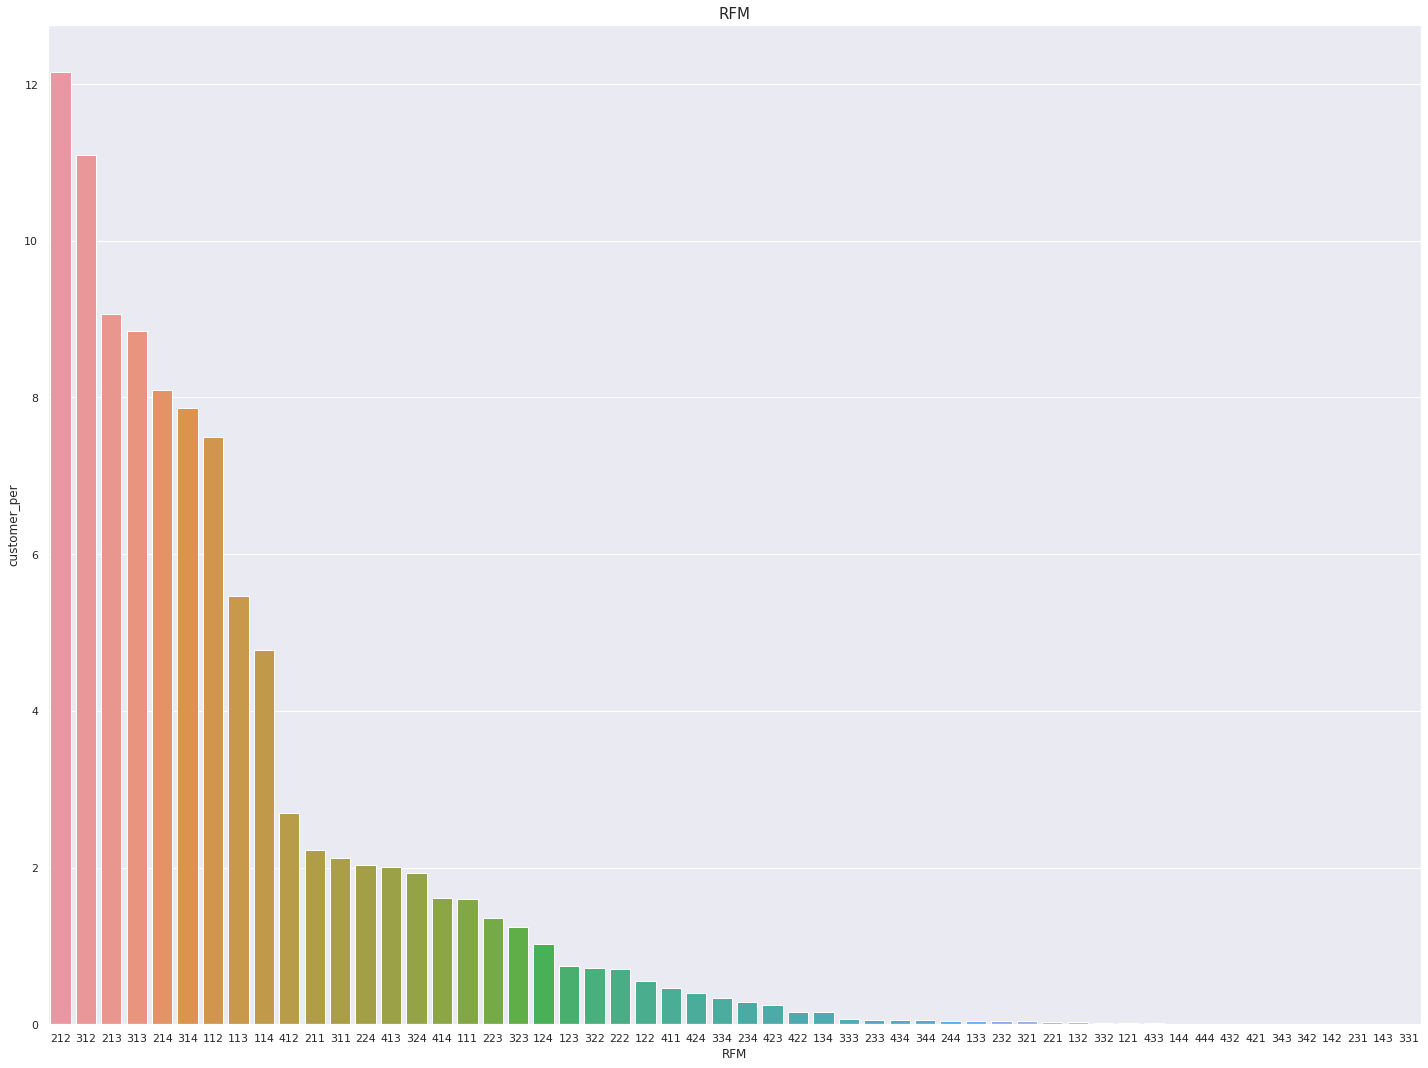

In [74]:
# Отобразим полученный результат на графике

fig, ax = plt.subplots(figsize = (20, 15))
sns.barplot(data = rfm_customer, x = 'RFM', y = 'customer_per')
ax.set_title('RFM', fontsize = 15)
plt.tight_layout()

Большая часть покупателей расположена в группе 212 и 312. Это те пользователи, у которых совершена одна покупка, последняя покупка от 1 до 6 месяцев назад, сумма всех покупок составляет от 20 до 70.

Группа 111: покупка совершена более года назад, единожды и сумму до 20. Такие покупатели не имеют ценности для магазина (скорее всего они пришли за конкретным товаром, который был на момент покупки дешевле, чем у конкурентов, или же они пришли только на время действия специальных скидок/акций). В любом случае, ориентироваться на эту группу пользователей не стоит и бороться за их удержаниею

Группа 444: часто делают покупки (больше 6 раз), средний чек больше 140, на момент проведения исследования последняя покупка совершена менее месяца назад. Такие пользователи очень активны и лояльны. Для бизнеса необходимо отслеживать изменения в их поведении и в случае каких-то отклонений разрабатывать мероприятия по вовлечению (лояльные и активные пользователи) 

Группа 144, 244, 134, 133 и т.д.: менее активные, в отличие от группы 444, но все еще лояльные. Для активного вовлечения стоит разработать специальные предложения, скидки, сделать рассылку.

Самые лучшие покупатели с из сегмента 444 - составляют всего 0.01 %

Интересно также посмотреть на график распределения по сегментам

In [75]:
# Для распределения по сегментам посчитаем средние метрик

rfm_mean = rfm_all.groupby('RFM', as_index = False) \
                  .agg({'R' : 'mean', 'F' : 'mean', 'M' : 'mean'})
rfm_mean

,RFM,R,F,M
0,111,466.679839,1.000000,15.922371
1,112,463.604432,1.000000,46.063108
2,113,464.202271,1.000000,103.766969
3,114,466.430110,1.000000,333.376287
4,121,458.176471,2.000000,16.214118
5,122,468.366990,2.066019,48.183515
6,123,456.857971,2.127536,104.874594
7,124,462.511435,2.192308,324.888576
8,132,469.875000,4.500000,50.998750
9,133,486.128205,4.512821,108.734872
